In [3]:
import cv2
import os
import random
import numpy as np
import pytesseract
from matplotlib import pyplot as plt

In [4]:
DATASET_PATH = r'./images/'
TARGET_WIDTH = 320
TARGET_HEIGHT = 80
PADDING = 5

PYTESSERACT_CONFIG = '--psm 10 -c tessedit_char_whitelist=0123456789'
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

In [5]:
def preprocess_image(image):
    original_image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT))
    image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)

    _, th3 = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    image = cv2.bitwise_not(th3)

    
    image = cv2.dilate(image, np.ones((1, 1), np.uint8), iterations=1)
    
    return image, original_image

In [6]:
def validate_character(character):
    character = character.strip()
    return character == '' or character == ' ' or character == None or len(character) > 1

In [10]:
def show_images(image_data):
    num_images = len(image_data)
    num_cols = 3 
    num_rows = int(np.ceil(num_images / num_cols)) * 2

    plt.figure(figsize=(15, 5 * (num_rows // 2))) 

    for i, (image, result_image) in enumerate(image_data):
        row_position = i // num_cols  
        col_position = i % num_cols 

        plt.subplot(num_rows, num_cols, row_position * num_cols * 2 + col_position + 1)
        plt.imshow(image, cmap='gray')
        plt.axis('off')  # Hide the axes

        plt.subplot(num_rows, num_cols, (row_position * num_cols * 2 + col_position + 1) + num_cols)
        plt.imshow(result_image, cmap='gray')
        plt.axis('off') 

    plt.tight_layout() 
    plt.show()

In [8]:
def segmentate(vertical_pixel_count: list):
    x_positions = []
    current_x = 0
    is_character = False
    for index, count in enumerate(vertical_pixel_count):
        if count == 0:
            if is_character:
                x_positions.append((current_x, index))
                is_character = False
            current_x = index
        else:
            is_character = True
        
    return x_positions

def segment_image(image, original_image=None, image_name='', type='write'):
    vertical_pixel_count = np.sum(image == 255, axis=0)
    
    positions = segmentate(vertical_pixel_count)
    
    for idx, (xStart, xEnd) in enumerate(positions):
        if type == 'write':
            character = pytesseract.image_to_string(image[:, xStart:xEnd], config='--psm 10 -c tessedit_char_whitelist=0123456789').strip()
            
            if character == '' or character == ' ' or character == None or len(character) > 1:
                continue
        
            name = f'{character.strip()}-{image_name.split(".")[0]}-{idx}.png'
            
            cv2.imwrite(f'./characters-2/{name}', image[:, xStart:xEnd])
        elif type == 'label':
            cv2.rectangle(original_image, (xStart, 0), (xEnd, TARGET_HEIGHT), (0, 255, 0), 2)
            
    return original_image

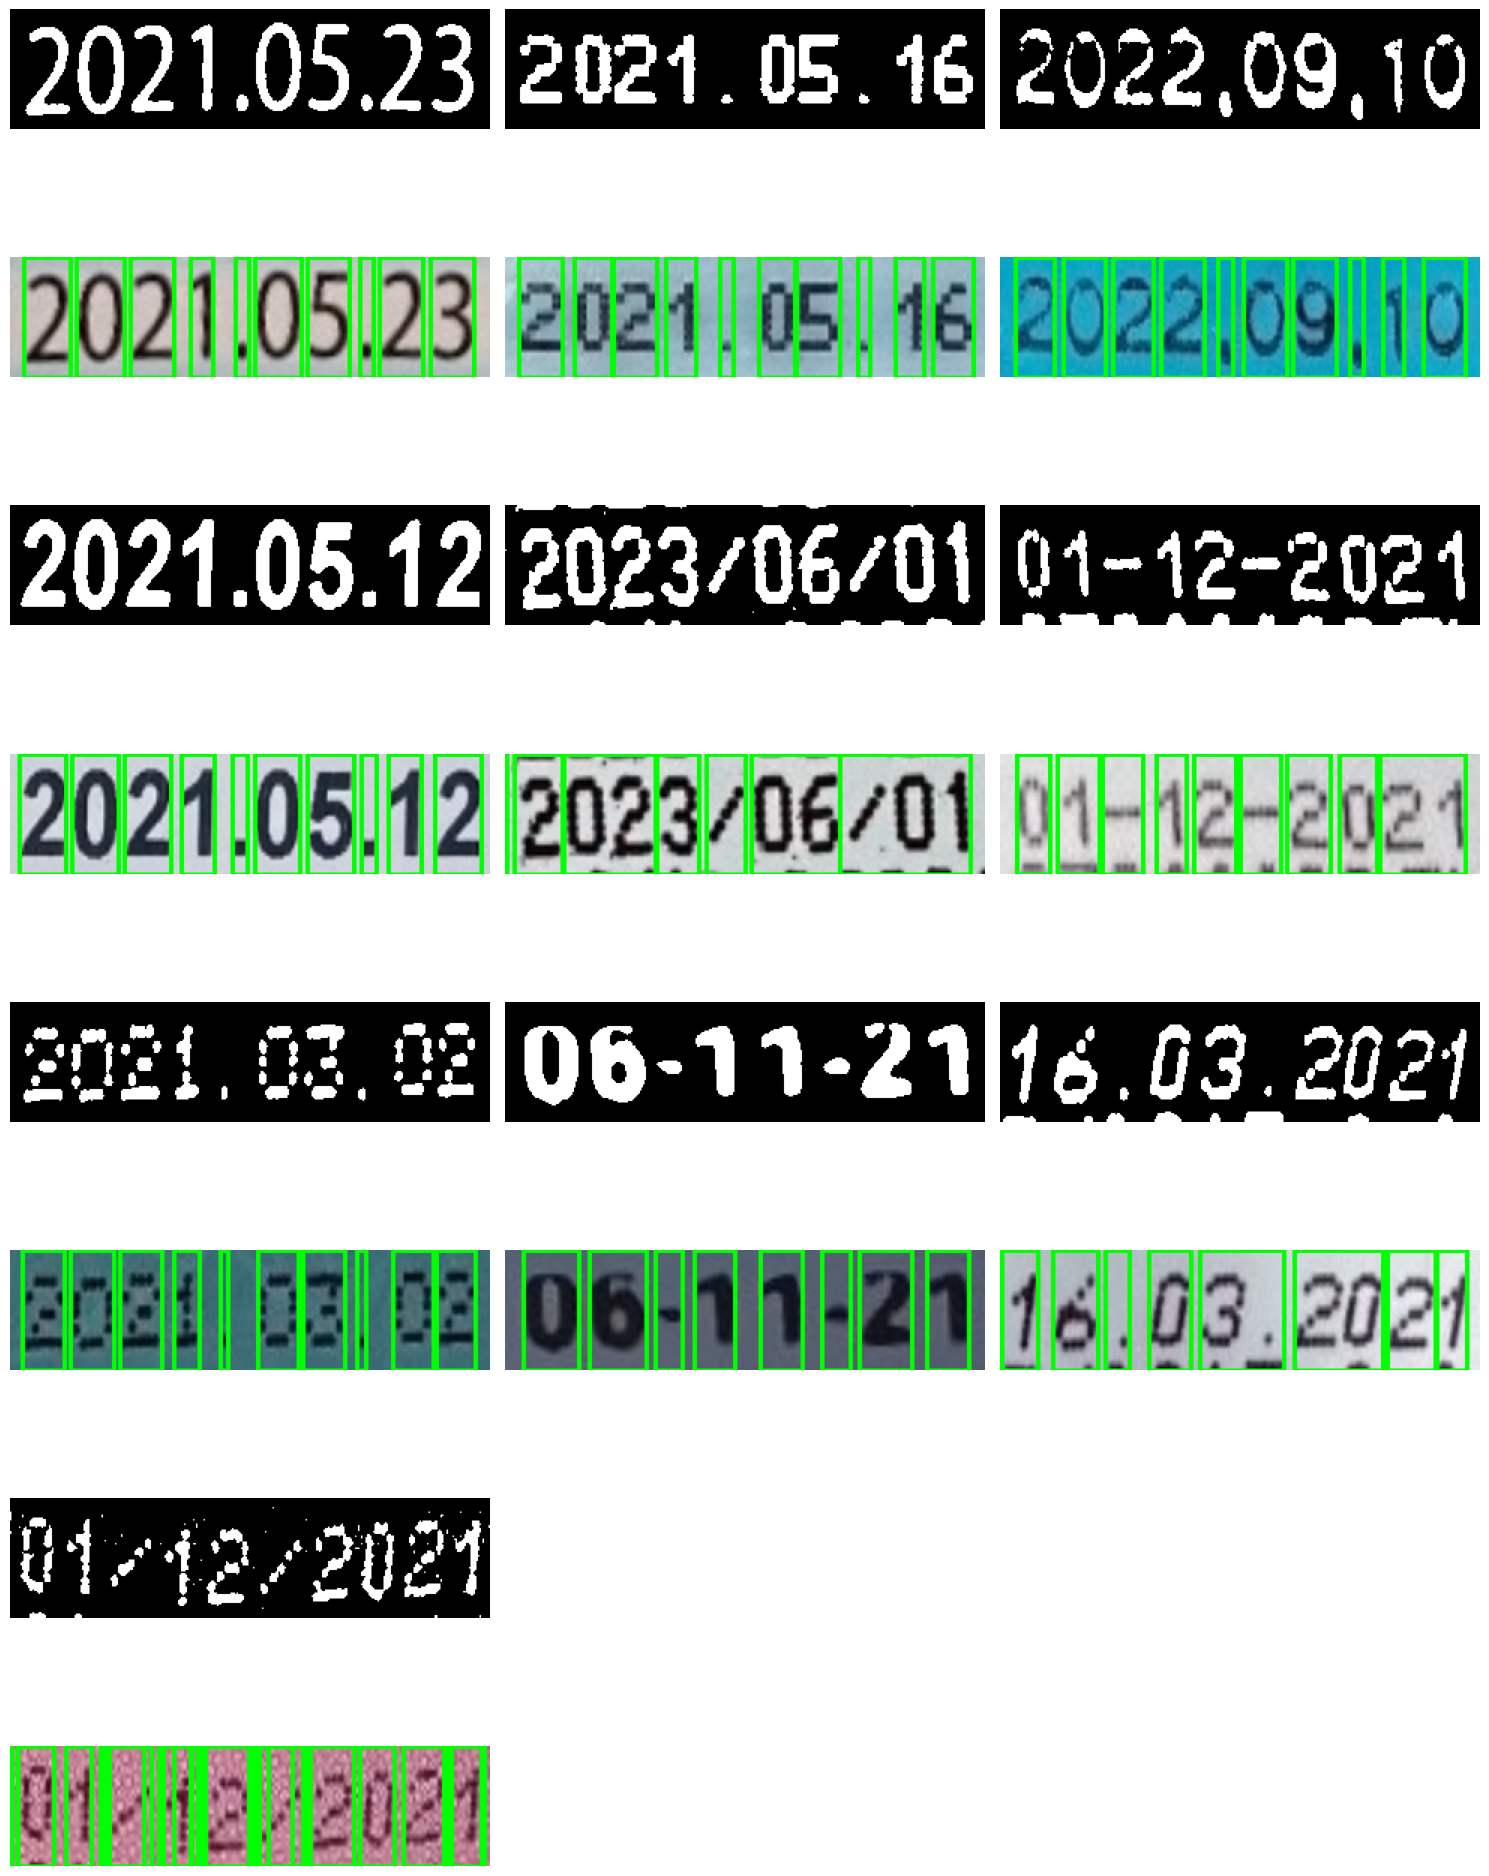

In [11]:
images = os.listdir(DATASET_PATH)

image_count = len(images)

image_data = []
for image_name in images[:10]:
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)
    
    image, original_image = preprocess_image(original_image)
    
    labeled_image = segment_image(image, original_image, image_name, type='label')
    
    image_data.append((image, labeled_image))
    
show_images(image_data)


In [12]:
images = os.listdir(DATASET_PATH)

image_count = len(images)

for data_count, image_name in enumerate(images):
    image_path = os.path.join(DATASET_PATH, image_name)
    
    original_image = cv2.imread(image_path)
    
    image, original_image = preprocess_image(original_image)
    
    segment_image(image, original_image, image_name, type='write')
            
    print(f'{data_count}/{image_count}')

0/510
1/510
2/510
3/510


KeyboardInterrupt: 